<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/Mixture_of_patches_classification_with_QMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture of patches classification with QMC



In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install --upgrade  git+https://github.com/fagonzalezo/qmc.git
    !pip install -U tensorflow-addons
else:
    import sys
    sys.path.insert(0, "../")



## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa
import qmc.tf.layers as layers
import qmc.tf.models as models

## Prepare the data

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (60000, 28, 28, 1) - y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000,)


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
batch_size = 256
num_epochs = 10
image_size = 28  # We'll resize input images to this size
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
input_dim = 64
num_rff = 512
gamma = 2**-5
n_comp = 80
random_state = 0

mlp_head_units = [256]  # Size of the dense layers of the final classifier


## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


2021-11-17 22:13:57.533050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 22:13:57.535500: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Implement multilayer perceptron (MLP)

In [6]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [7]:

class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 49


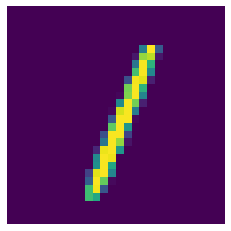

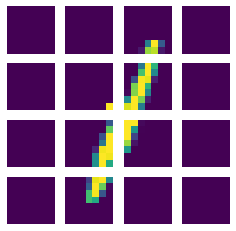

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.reshape([image_size, image_size]))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8").reshape([patch_size, patch_size]))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [9]:
positional_embeddings = np.zeros((num_patches, projection_dim))
for position in range(num_patches):
    for i in range(0, projection_dim, 2):
       positional_embeddings[position, i] = (
                                          np.sin(position / (10000 ** ((2*i) / projection_dim)))
                                            )
       positional_embeddings[position, i + 1] = (
                                              np.cos(position / (10000 ** ((2 * (i + 1) ) / projection_dim)))
                                                )


class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = tf.Variable(initial_value=positional_embeddings,
                                              dtype=tf.float32, 
                                              trainable=False)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.position_embedding = tf.Variable(initial_value=positional_embeddings,
                                      dtype=tf.float32, 
                                      trainable=False)


    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        #encoded = self.projection(patch) + self.position_embedding(positions)
        #encoded = self.projection(patch) + self.position_embedding
        encoded = self.projection(patch)
        return encoded


## Build QMC model


In [28]:

def create_QMC_model():
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    # encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    fm_x1 = layers.QFeatureMapRFF(49, dim=num_rff , gamma=gamma)
    psi_x = tf.transpose(fm_x1(patches), perm=[0, 2, 1])
    ones = tf.ones_like(psi_x[:, 0:1, :], dtype=tf.float32) / num_patches
    rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
    qmdmc = layers.QMClassifSDecompFDMatrix(dim_x=num_rff, dim_y=10, n_comp=n_comp)
    rho_y = qmdmc(rho_x)
    y_w = rho_y[:, 0, :] # shape (b, d_in)
    y_v = rho_y[:, 1:, :] # shape (b, dim_x, d_in)
    probs = tf.einsum('...j,...ij,...ij->...i', y_w, y_v, tf.math.conj(y_v))
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=probs)
    return model


In [36]:
model = create_QMC_model()
model.summary()
model.layers[3].trainable = False

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 28, 28, 1)    3           input_17[0][0]                   
__________________________________________________________________________________________________
patches_17 (Patches)            (None, 16, 49)       0           data_augmentation[16][0]         
__________________________________________________________________________________________________
q_feature_map_rff_16 (QFeatureM (None, 16, 512)      25600       patches_17[0][0]                 
___________________________________________________________________________________________

## Compile, train, and evaluate the mode

In [37]:

def run_experiment(model):
    optimizer = tf.optimizers.Adam(
        learning_rate=learning_rate
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


QMC_model = create_QMC_model()
history = run_experiment(QMC_model)


Epoch 1/10
211/211 [==============================] - 17s 79ms/step - loss: 1.8974 - accuracy: 0.4679 - val_loss: 1.6858 - val_accuracy: 0.6455
Epoch 2/10
211/211 [==============================] - 17s 80ms/step - loss: 1.6734 - accuracy: 0.6248 - val_loss: 1.6238 - val_accuracy: 0.6765
Epoch 3/10
211/211 [==============================] - 17s 80ms/step - loss: 1.6241 - accuracy: 0.6591 - val_loss: 1.5908 - val_accuracy: 0.6373
Epoch 4/10
211/211 [==============================] - 17s 81ms/step - loss: 1.5975 - accuracy: 0.6801 - val_loss: 1.5638 - val_accuracy: 0.7112
Epoch 5/10
211/211 [==============================] - 17s 80ms/step - loss: 1.5787 - accuracy: 0.6982 - val_loss: 1.5483 - val_accuracy: 0.7022
Epoch 6/10
211/211 [==============================] - 17s 80ms/step - loss: 1.5661 - accuracy: 0.7074 - val_loss: 1.5376 - val_accuracy: 0.7578
Epoch 7/10
211/211 [==============================] - 18s 84ms/step - loss: 1.5534 - accuracy: 0.7141 - val_loss: 1.5271 - val_accuracy: